In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Ler base de dados

In [2]:
# Obter dados
df_enem = pd.read_pickle('Bases\Finais\enem_censo_2023_full.pkl')

#Variaveis alvo
variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']

# separar em treino e teste
X = df_enem.drop(columns=variaveis_alvo)
y = df_enem[variaveis_alvo]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de tipo para MLflow -> Converter colunas inteiras para float
X_train = X_train.astype({col: 'float' for col in X_train.select_dtypes('int').columns})
X_test = X_test.astype({col: 'float' for col in X_test.select_dtypes('int').columns})

# Obter colunas categóricas
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()

# Criar Eval Set para validação cruzada (15% do conjunto de treino)
# Apenas utilizado nos modelos fianais, BayesSearchCV não utiliza Eval Set já possui validacao cruzada interna
X_train_final, X_eval, y_train_final, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=42
)

Carregar modelo

In [3]:
# Carregar modelo treinado
with open('modelos/modelo_lgbm_bayes_censo_enem.pkl', 'rb') as file:
    model = joblib.load(file)

### Avaliação de importância das variáveis

    O gain representa uma quantidade numérica de melhoria no critério de divisão, ou seja, o quanto o erro da árvore foi reduzido ao usar uma determinada feature em um split.

    O split conta quantas vezes uma feature foi usada para fazer uma divisão (split) nas árvores do modelo.

    GAIN: "A feature X foi responsável por n% da redução total do erro nas árvores."
    SPLIT: "A feature Y foi usada em k% dos splits feitos pelo modelo."

Features usadas com frequência, mas que não trazem muito ganho → talvez pouco informativas.

Features usadas poucas vezes, mas com alto ganho → talvez valiosas, mas subexploradas.

In [4]:
df_gain = pd.DataFrame({
    'Feature': X_train.columns,
    'Gain': model.booster_.feature_importance(importance_type='gain')
})
df_split = pd.DataFrame({
    'Feature': X_train.columns,
    'Split': model.booster_.feature_importance(importance_type='split')
})

# Junta os dois
df_comparado = df_gain.merge(df_split, on='Feature')

# Normaliza
df_comparado['Gain (%)'] = 100 * df_comparado['Gain'] / df_comparado['Gain'].sum()
df_comparado['Split (%)'] = 100 * df_comparado['Split'] / df_comparado['Split'].sum()

# Arredonda para duas casas decimais
df_comparado['Gain (%)'] = df_comparado['Gain (%)'].round(4)
df_comparado['Split (%)'] = df_comparado['Split (%)'].round(4)

display(df_comparado.sort_values(by='Gain (%)', ascending=False))


,Feature,Gain,Split,Gain (%),Split (%)
25,NUM_Q006,3.660375e+09,1330,10.0927,1.8269
15,CAT_LINGUA,3.324500e+09,485,9.1666,0.6662
40,CAT_MODE_CATEGORIA_ESCOLA_PRIVADA,1.921521e+09,110,5.2982,0.1511
39,NUM_Q024,1.774369e+09,799,4.8925,1.0975
85,NUM_PERC_MANT_ESCOLA_PRIVADA_EMP,1.566845e+09,581,4.3203,0.7981
...,...,...,...,...,...
66,NUM_PERC_AGUA_INEXISTENTE,4.690548e+06,138,0.0129,0.1896
72,NUM_PERC_ENERGIA_INEXISTENTE,4.046870e+06,174,0.0112,0.2390
42,CAT_MODE_LOCALIZACAO_DIFERENCIADA,3.731096e+06,81,0.0103,0.1113
104,NUM_PERC_VINCULO_SECRETARIA_SAUDE,1.530509e+06,42,0.0042,0.0577


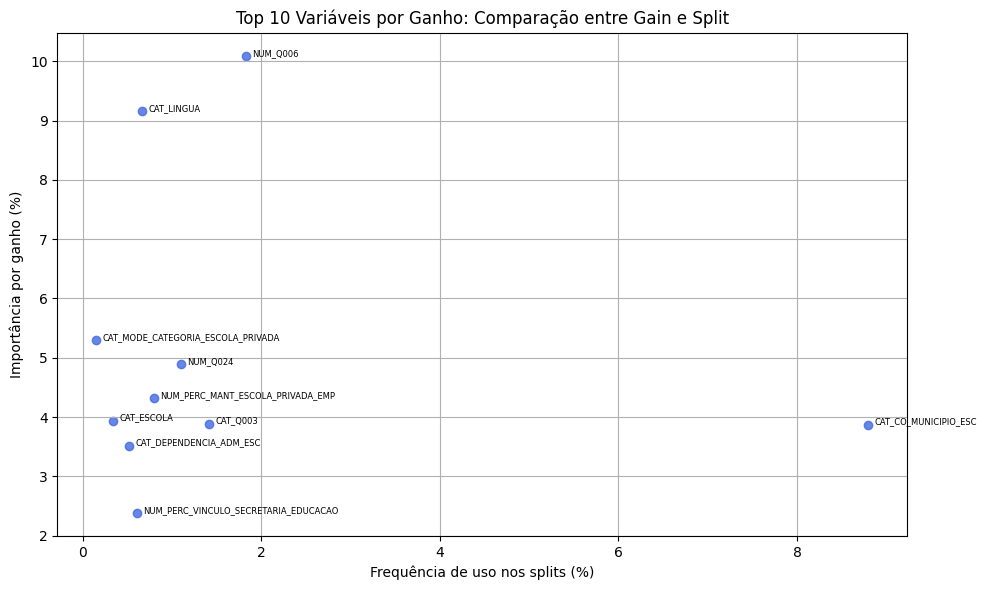

In [5]:
# Considerando que df já possui as colunas:
# 'Feature', 'Gain (%)', 'Split (%)'

# Definindo o número de features a serem plotadas
top = 10

# Ordena por ganho e seleciona os top primeiros
df_top = df_comparado.sort_values(by='Gain (%)', ascending=False).head(top)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_top['Split (%)'], df_top['Gain (%)'], alpha=0.8, color='royalblue')

# Adiciona os nomes das features
for _, row in df_top.iterrows():
    plt.text(row['Split (%)'] + 0.07, row['Gain (%)'], row['Feature'], fontsize=6)

# Estética
plt.xlabel('Frequência de uso nos splits (%)')
plt.ylabel('Importância por ganho (%)')
plt.title(f'Top {top} Variáveis por Ganho: Comparação entre Gain e Split')
plt.grid(True)
plt.tight_layout()
plt.show()


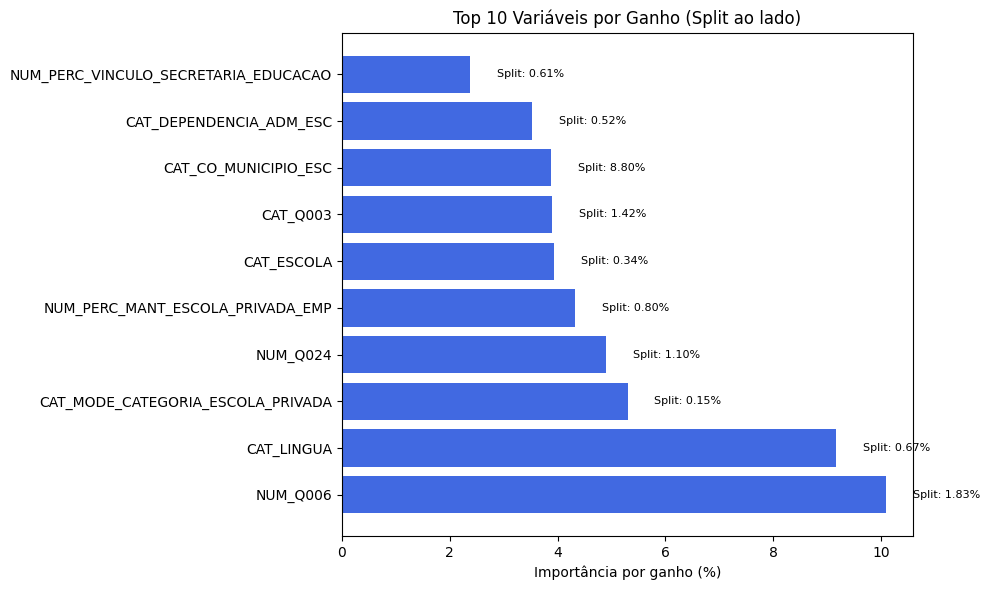

In [6]:
plt.figure(figsize=(10, 6))
bars = plt.barh(df_top['Feature'], df_top['Gain (%)'], color='royalblue')
for i, (gain, split) in enumerate(zip(df_top['Gain (%)'], df_top['Split (%)'])):
    plt.text(gain + 0.5, i, f"Split: {split:.2f}%", va='center', fontsize=8)
plt.xlabel('Importância por ganho (%)')
plt.title(f'Top {top} Variáveis por Ganho (Split ao lado)')
plt.tight_layout()
plt.show()

In [7]:
nomes_descritivos_enem = {
    'CAT_FAIXA_ETARIA': 'Faixa etária',
    'CAT_SEXO': 'Sexo',
    'CAT_ESTADO_CIVIL': 'Estado civil',
    'CAT_COR_RACA': 'Cor/raça',
    'CAT_NACIONALIDADE': 'Nacionalidade',
    'CAT_ESCOLA': 'Tipo de escola',
    'CAT_ENSINO': 'Tipo de instituição',
    'CAT_CO_MUNICIPIO_ESC': 'Cód. município',
    'CAT_CO_UF_ESC': 'UF escola',
    'CAT_DEPENDENCIA_ADM_ESC': 'Dependência administrativa',
    'CAT_LOCALIZACAO_ESC': 'Localização',
    'CAT_SIT_FUNC_ESC': 'Sit. funcionamento escola',
    'NUM_NOTA_CN': 'Nota Ciências Natureza',
    'NUM_NOTA_CH': 'Nota Ciências Humanas',
    'NUM_NOTA_LC': 'Nota Linguagens',
    'NUM_NOTA_MT': 'Nota Matemática',
    'CAT_LINGUA': 'Língua estrangeira',
    'NUM_NOTA_REDACAO': 'Nota redação',
    'NUM_Q001': 'Grau estudo pai',
    'BIN_Q001_DUMMY_H': 'Não sabe grau estudo pai',
    'NUM_Q002': 'Grau estudo mãe',
    'BIN_Q002_DUMMY_H': 'Não sabe grau estudo mãe',
    'CAT_Q003': 'Ocupação pai',
    'CAT_Q004': 'Ocupação mãe',
    'NUM_Q005': 'Pessoas na residência',
    'NUM_Q006': 'Renda familiar mensal',
    'NUM_Q007': 'Dias empregado(a) doméstico(a)',
    'NUM_Q008': 'Qtde. banheiros',
    'NUM_Q009': 'Qtde. quartos',
    'NUM_Q010': 'Qtde. carros',
    'NUM_Q011': 'Qtde. motocicletas',
    'NUM_Q012': 'Qtde. geladeiras',
    'NUM_Q013': 'Qtde. freezers',
    'NUM_Q014': 'Qtde. máq. lavar roupa',
    'NUM_Q015': 'Qtde. máq. secar roupa',
    'NUM_Q016': 'Qtde. micro-ondas',
    'NUM_Q017': 'Qtde. máq. lavar louça',
    'BIN_Q018': 'Possui aspirador',
    'NUM_Q019': 'Qtde. TVs',
    'BIN_Q020': 'Possui DVD',
    'BIN_Q021': 'Possui TV por assinatura',
    'NUM_Q022': 'Qtde. celulares',
    'BIN_Q023': 'Possui telefone fixo',
    'NUM_Q024': 'Qtde. computadores',
    'BIN_Q025': 'Possui internet'
}

nomes_descritivos_censo = {
    'CHA_CO_MUNICIPIO': 'Cód. município',
    'CAT_MODE_ORGAO_REGIONAL': 'Órgão regional',
    'CAT_MODE_REGIAO': 'Região geográfica',
    'NUM_PERC_AGUA_INEXISTENTE': 'Sem água',
    'NUM_PERC_AGUA_POTAVEL': 'Água potável',
    'NUM_PERC_AREA_VERDE': 'Área verde',
    'NUM_PERC_AUDITORIO': 'Auditório',
    'NUM_PERC_BANHEIRO': 'Banheiro',
    'NUM_PERC_BIBLIOTECA': 'Biblioteca',
    'NUM_PERC_ENERGIA_INEXISTENTE': 'Sem energia',
    'NUM_PERC_ESGOTO_INEXISTENTE': 'Sem esgoto',
    'CAT_MODE_EXAME_SELECAO': 'Exame seleção',
    'NUM_PERC_INTERNET_ALUNOS': 'Internet alunos',
    'NUM_PERC_INTERNET_APRENDIZAGEM': 'Internet ensino',
    'NUM_PERC_LABORATORIO_CIENCIAS': 'Lab. ciências',
    'NUM_PERC_LABORATORIO_INFORMATICA': 'Lab. informática',
    'NUM_PERC_LOCAL_FUNC_GALPAO': 'Funciona galpão',
    'NUM_PERC_LOCAL_FUNC_OUTROS': 'Funciona outros',
    'NUM_PERC_LOCAL_FUNC_PREDIO_ESCOLAR': 'Funciona prédio escolar',
    'NUM_PERC_LOCAL_FUNC_PRISIONAL_SOCIO': 'Funciona prisional/socio',
    'NUM_PERC_LOCAL_FUNC_SALAS_OUTRA_ESC': 'Funciona outra escola',
    'NUM_PERC_LOCAL_FUNC_SOCIOEDUCATIVO': 'Funciona socioeducativo',
    'NUM_PERC_LOCAL_FUNC_UNID_PRISIONAL': 'Funciona prisional',
    'NUM_PERC_MANT_ESCOLA_PRIV_ONG_OSCIP': 'Mantened. ONG/OSCIP',
    'NUM_PERC_MANT_ESCOLA_PRIVADA_EMP': 'Empresa privada mantened.',
    'NUM_PERC_MANT_ESCOLA_PRIVADA_ONG': 'Mantened. ONG',
    'NUM_PERC_MANT_ESCOLA_PRIVADA_OSCIP': 'Mantened. OSCIP',
    'NUM_PERC_MANT_ESCOLA_PRIVADA_S_FINS': 'Mantened. sem fins lucr.',
    'NUM_PERC_MANT_ESCOLA_PRIVADA_SIND': 'Mantened. sindicato',
    'NUM_PERC_MANT_ESCOLA_PRIVADA_SIST_S': 'Mantened. sistema S',
    'NUM_PERC_MATERIAL_PED_NENHUM': 'Sem material pedagógico',
    'NUM_PERC_MEDIACAO_EAD': 'Aulas EAD',
    'NUM_PERC_MEDIACAO_PRESENCIAL': 'Aulas presenciais',
    'NUM_PERC_MEDIACAO_SEMIPRESENCIAL': 'Aulas semipresenciais',
    'NUM_PERC_PISCINA': 'Piscina',
    'NUM_PERC_PODER_PUBLICO_PARCERIA': 'Parceria poder público',
    'NUM_PERC_PROF_TEC': 'Educação profissional',
    'NUM_PERC_QUADRA_ESPORTES': 'Quadra esportes',
    'NUM_PERC_SALA_ATELIE_ARTES': 'Sala artes',
    'NUM_PERC_SALA_MUSICA_CORAL': 'Sala música',
    'CAT_MODE_TRATAMENTO_LIXO_INEXISTENTE': 'Sem tratamento lixo',
    'NUM_PERC_VINCULO_OUTRO_ORGAO': 'Vínculo outro órgão',
    'NUM_PERC_VINCULO_SECRETARIA_EDUCACAO': 'Vínculo Sec. Educação',
    'NUM_PERC_VINCULO_SECRETARIA_SAUDE': 'Vínculo Sec. Saúde',
    'NUM_PERC_VINCULO_SEGURANCA_PUBLICA': 'Vínculo Seg. Pública',
    'NUM_MEAN_COMP_PORTATIL_ALUNO': 'Qtde. notebooks alunos',
    'NUM_MEAN_DESKTOP_ALUNO': 'Qtde. desktop alunos',
    'NUM_MEAN_DOC_MED': 'Docentes ens. médio',
    'NUM_MEAN_EQUIP_LOUSA_DIGITAL': 'Qtde. lousas digitais',
    'NUM_MEAN_EQUIP_MULTIMIDIA': 'Qtde. projetores',
    'NUM_MEAN_EQUIP_TV': 'Qtde. televisores',
    'NUM_MEAN_MAT_MED': 'Matrículas ens. médio',
    'NUM_MEAN_MAT_MED_INT': 'Matrículas tempo integral',
    'NUM_MEAN_MAT_MED_NM': 'Matrículas normal/magistério',
    'NUM_MEAN_PROF_BIBLIOTECARIO': 'Qtde. bibliotecários',
    'NUM_MEAN_PROF_MONITORES': 'Qtde. monitores',
    'NUM_MEAN_PROF_PSICOLOGO': 'Qtde. psicólogos',
    'NUM_MEAN_PROF_PEDAGOGIA': 'Qtde. pedagogos',
    'NUM_MEAN_SALAS_UTILIZADAS': 'Qtde. salas aula',
    'NUM_MEAN_TABLET_ALUNO': 'Qtde. tablets alunos',
    'NUM_MEAN_TUR_MED': 'Turmas ens. médio',
    'NUM_MEAN_TUR_MED_INT': 'Turmas tempo integral',
    'CAT_MODE_CATEGORIA_ESCOLA_PRIVADA': 'Categoria escola privada',
    'CHA_DEPENDENCIA': 'Dependência administrativa',
    'CHA_LOCALIZACAO': 'Localização',
    'CAT_MODE_LOCALIZACAO_DIFERENCIADA': 'Localização diferenciada',
    'CAT_MODE_OCUPACAO_GALPAO': 'Ocupação galpão',
    'CAT_MODE_OCUPACAO_PREDIO_ESCOLAR': 'Ocupação prédio escolar',
    'CAT_MODE_PROPOSTA_PEDAGOGICA': 'Proposta pedagógica atualizada',
}

nomes_descritivos = {**nomes_descritivos_enem, **nomes_descritivos_censo}

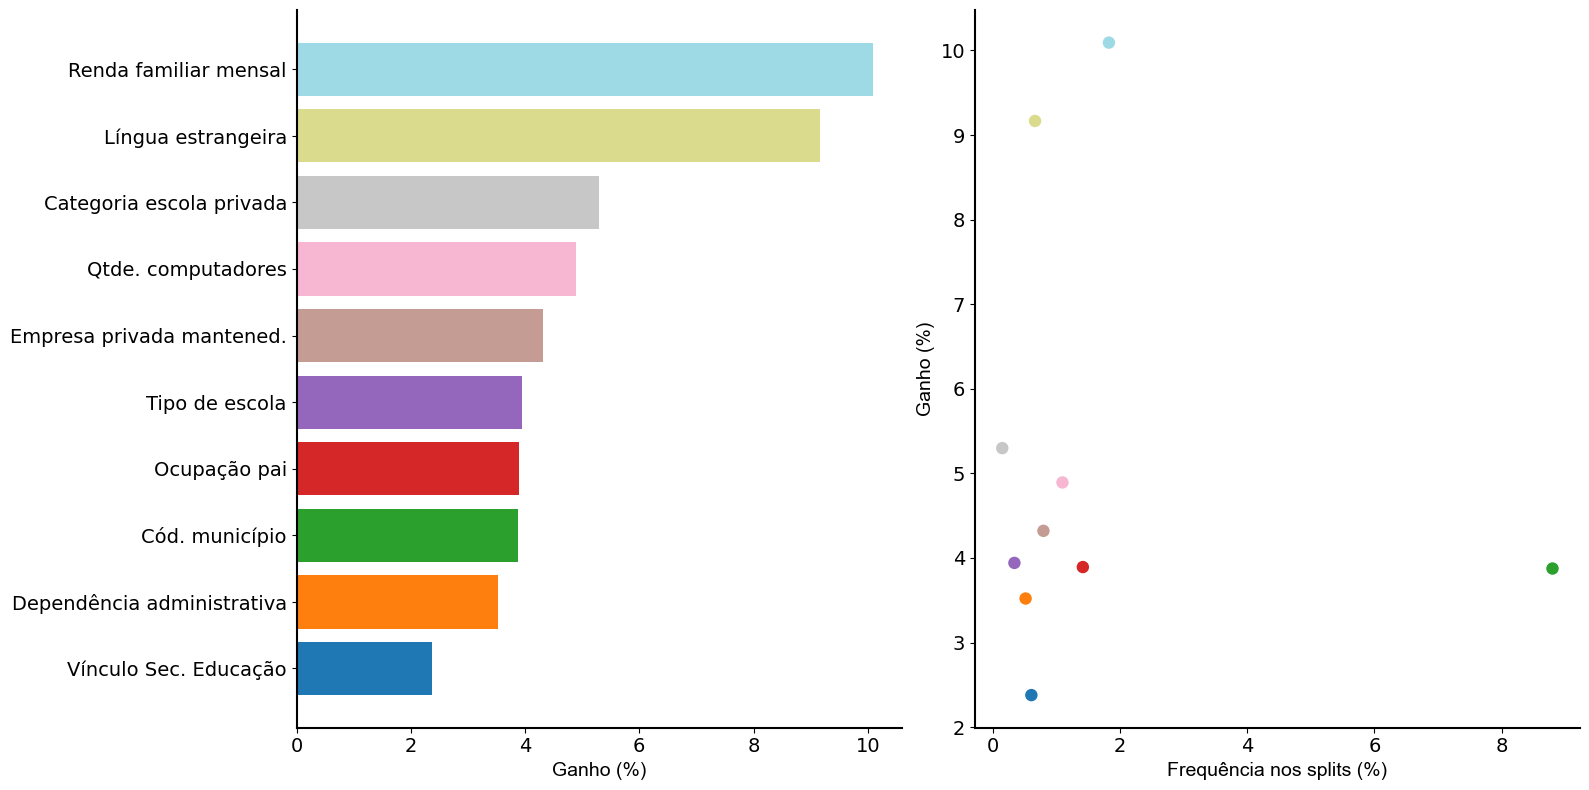

In [8]:
top = 10  # Altere aqui para o número desejado entre 2 e 20

# Substitui os nomes das features pelos nomes descritivos, se existirem no dicionário
df_top = df_comparado.sort_values(by='Gain (%)', ascending=False).head(top).sort_values(by='Gain (%)').copy()
df_top['Feature_Desc'] = df_top['Feature'].map(nomes_descritivos).fillna(df_top['Feature'])

# Paleta de cores dinâmica
cmap = plt.get_cmap('tab20', top)
colors = [cmap(i) for i in range(top)]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico de barras horizontais (Ganho)
axes[0].barh(df_top['Feature_Desc'], df_top['Gain (%)'], color=colors, edgecolor='none')
axes[0].set_xlabel('Ganho (%)', fontname='Arial', fontsize=14, color='black')
axes[0].set_ylabel('', fontname='Arial', fontsize=14, color='black')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_color('black')
axes[0].spines['bottom'].set_linewidth(1.5)
axes[0].spines['left'].set_color('black')
axes[0].spines['left'].set_linewidth(1.5)
axes[0].tick_params(axis='x', colors='black', labelsize=14)
axes[0].tick_params(axis='y', colors='black', labelsize=14)
axes[0].set_title('')  # Remove título
axes[0].grid(False)

# Gráfico de dispersão (Split x Ganho)
axes[1].scatter(df_top['Split (%)'], df_top['Gain (%)'], color=colors, s=80, edgecolor='none')
axes[1].set_xlabel('Frequência nos splits (%)', fontname='Arial', fontsize=14, color='black')
axes[1].set_ylabel('Ganho (%)', fontname='Arial', fontsize=14, color='black')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_color('black')
axes[1].spines['bottom'].set_linewidth(1.5)
axes[1].spines['left'].set_color('black')
axes[1].spines['left'].set_linewidth(1.5)
axes[1].tick_params(axis='x', colors='black', labelsize=14)
axes[1].tick_params(axis='y', colors='black', labelsize=14)
axes[1].set_title('')  # Remove título
axes[1].grid(False)

plt.tight_layout()
plt.show()

Analise escolar vs socioeconomico por ganho

In [9]:
colunas_socioeconomicas = [
    "BIN_Q001_DUMMY_H", "BIN_Q002_DUMMY_H", "BIN_Q018", "BIN_Q020", "BIN_Q021", "BIN_Q023", "BIN_Q025", "CAT_COR_RACA",
    "CAT_ESTADO_CIVIL", "CAT_FAIXA_ETARIA", "CAT_LINGUA", "CAT_NACIONALIDADE", "CAT_Q003", "CAT_Q004", "CAT_SEXO",
    "NUM_Q001", "NUM_Q002", "NUM_Q005", "NUM_Q006", "NUM_Q007", "NUM_Q008", "NUM_Q009", "NUM_Q010", "NUM_Q011",
    "NUM_Q012", "NUM_Q013", "NUM_Q014", "NUM_Q015", "NUM_Q016", "NUM_Q017", "NUM_Q019", "NUM_Q022", "NUM_Q024"
]

colunas_escolares = [
    "CAT_CO_MUNICIPIO_ESC", "CAT_CO_UF_ESC", "CAT_DEPENDENCIA_ADM_ESC", "CAT_ENSINO", "CAT_ESCOLA", "CAT_LOCALIZACAO_ESC", "CAT_SIT_FUNC_ESC",
    "CAT_MODE_CATEGORIA_ESCOLA_PRIVADA", "CAT_MODE_EXAME_SELECAO", "CAT_MODE_LOCALIZACAO_DIFERENCIADA", "CAT_MODE_OCUPACAO_GALPAO",
    "CAT_MODE_OCUPACAO_PREDIO_ESCOLAR", "CAT_MODE_ORGAO_REGIONAL", "CAT_MODE_PROPOSTA_PEDAGOGICA", "CAT_MODE_REGIAO",
    "CAT_MODE_TRATAMENTO_LIXO_INEXISTENTE",
    "NUM_MEAN_COMP_PORTATIL_ALUNO", "NUM_MEAN_DESKTOP_ALUNO", "NUM_MEAN_DOC_MED", "NUM_MEAN_EQUIP_LOUSA_DIGITAL",
    "NUM_MEAN_EQUIP_MULTIMIDIA", "NUM_MEAN_EQUIP_TV", "NUM_MEAN_MAT_MED", "NUM_MEAN_MAT_MED_INT",
    "NUM_MEAN_MAT_MED_NM", "NUM_MEAN_PROF_BIBLIOTECARIO", "NUM_MEAN_PROF_MONITORES", "NUM_MEAN_PROF_PEDAGOGIA",
    "NUM_MEAN_PROF_PSICOLOGO", "NUM_MEAN_SALAS_UTILIZADAS", "NUM_MEAN_TABLET_ALUNO", "NUM_MEAN_TUR_MED",
    "NUM_MEAN_TUR_MED_INT", "NUM_PERC_AGUA_INEXISTENTE", "NUM_PERC_AGUA_POTAVEL", "NUM_PERC_AREA_VERDE",
    "NUM_PERC_AUDITORIO", "NUM_PERC_BANHEIRO", "NUM_PERC_BIBLIOTECA", "NUM_PERC_ENERGIA_INEXISTENTE",
    "NUM_PERC_ESGOTO_INEXISTENTE", "NUM_PERC_INTERNET_ALUNOS", "NUM_PERC_INTERNET_APRENDIZAGEM", "NUM_PERC_LABORATORIO_CIENCIAS",
    "NUM_PERC_LABORATORIO_INFORMATICA", "NUM_PERC_LOCAL_FUNC_GALPAO", "NUM_PERC_LOCAL_FUNC_OUTROS", "NUM_PERC_LOCAL_FUNC_PREDIO_ESCOLAR",
    "NUM_PERC_LOCAL_FUNC_PRISIONAL_SOCIO", "NUM_PERC_LOCAL_FUNC_SALAS_OUTRA_ESC", "NUM_PERC_LOCAL_FUNC_SOCIOEDUCATIVO", "NUM_PERC_LOCAL_FUNC_UNID_PRISIONAL",
    "NUM_PERC_MANT_ESCOLA_PRIVADA_EMP", "NUM_PERC_MANT_ESCOLA_PRIVADA_ONG", "NUM_PERC_MANT_ESCOLA_PRIVADA_OSCIP", "NUM_PERC_MANT_ESCOLA_PRIVADA_SIND",
    "NUM_PERC_MANT_ESCOLA_PRIVADA_SIST_S", "NUM_PERC_MANT_ESCOLA_PRIVADA_S_FINS", "NUM_PERC_MANT_ESCOLA_PRIV_ONG_OSCIP", "NUM_PERC_MATERIAL_PED_NENHUM",
    "NUM_PERC_MEDIACAO_EAD", "NUM_PERC_MEDIACAO_PRESENCIAL", "NUM_PERC_MEDIACAO_SEMIPRESENCIAL", "NUM_PERC_PISCINA",
    "NUM_PERC_PODER_PUBLICO_PARCERIA", "NUM_PERC_PROF_TEC", "NUM_PERC_QUADRA_ESPORTES", "NUM_PERC_SALA_ATELIE_ARTES",
    "NUM_PERC_SALA_MUSICA_CORAL", "NUM_PERC_VINCULO_OUTRO_ORGAO", "NUM_PERC_VINCULO_SECRETARIA_EDUCACAO", "NUM_PERC_VINCULO_SECRETARIA_SAUDE",
    "NUM_PERC_VINCULO_SEGURANCA_PUBLICA"
]

colunas_microdados_enem = [
    "BIN_Q001_DUMMY_H", "BIN_Q002_DUMMY_H", "BIN_Q018",
    "BIN_Q020", "BIN_Q021", "BIN_Q023", "BIN_Q025", "CAT_COR_RACA",  
    "CAT_ENSINO", "CAT_ESCOLA", "CAT_ESTADO_CIVIL", "CAT_FAIXA_ETARIA",
    "CAT_LINGUA", "CAT_NACIONALIDADE", "CAT_Q003", "CAT_Q004", "CAT_SEXO", "CAT_SIT_FUNC_ESC",
    "NUM_Q001", "NUM_Q002", "NUM_Q005", "NUM_Q006", "NUM_Q007", "NUM_Q008", "NUM_Q009", "NUM_Q010", "NUM_Q011",
    "NUM_Q012", "NUM_Q013", "NUM_Q014", "NUM_Q015", "NUM_Q016", "NUM_Q017", "NUM_Q019", "NUM_Q022", "NUM_Q024"
]

colunas_microdados_censo_escolar = [
    "CAT_MODE_CATEGORIA_ESCOLA_PRIVADA", "CAT_MODE_EXAME_SELECAO", "CAT_MODE_LOCALIZACAO_DIFERENCIADA", "CAT_MODE_OCUPACAO_GALPAO",
    "CAT_MODE_OCUPACAO_PREDIO_ESCOLAR", "CAT_MODE_ORGAO_REGIONAL", "CAT_MODE_PROPOSTA_PEDAGOGICA", "CAT_MODE_REGIAO",
    "CAT_MODE_TRATAMENTO_LIXO_INEXISTENTE",
    "NUM_MEAN_COMP_PORTATIL_ALUNO", "NUM_MEAN_DESKTOP_ALUNO", "NUM_MEAN_DOC_MED", "NUM_MEAN_EQUIP_LOUSA_DIGITAL",
    "NUM_MEAN_EQUIP_MULTIMIDIA", "NUM_MEAN_EQUIP_TV", "NUM_MEAN_MAT_MED", "NUM_MEAN_MAT_MED_INT",
    "NUM_MEAN_MAT_MED_NM", "NUM_MEAN_PROF_BIBLIOTECARIO", "NUM_MEAN_PROF_MONITORES", "NUM_MEAN_PROF_PEDAGOGIA",
    "NUM_MEAN_PROF_PSICOLOGO", "NUM_MEAN_SALAS_UTILIZADAS", "NUM_MEAN_TABLET_ALUNO", "NUM_MEAN_TUR_MED",
    "NUM_MEAN_TUR_MED_INT", "NUM_PERC_AGUA_INEXISTENTE", "NUM_PERC_AGUA_POTAVEL", "NUM_PERC_AREA_VERDE",
    "NUM_PERC_AUDITORIO", "NUM_PERC_BANHEIRO", "NUM_PERC_BIBLIOTECA", "NUM_PERC_ENERGIA_INEXISTENTE",
    "NUM_PERC_ESGOTO_INEXISTENTE", "NUM_PERC_INTERNET_ALUNOS", "NUM_PERC_INTERNET_APRENDIZAGEM", "NUM_PERC_LABORATORIO_CIENCIAS",
    "NUM_PERC_LABORATORIO_INFORMATICA", "NUM_PERC_LOCAL_FUNC_GALPAO", "NUM_PERC_LOCAL_FUNC_OUTROS", "NUM_PERC_LOCAL_FUNC_PREDIO_ESCOLAR",
    "NUM_PERC_LOCAL_FUNC_PRISIONAL_SOCIO", "NUM_PERC_LOCAL_FUNC_SALAS_OUTRA_ESC", "NUM_PERC_LOCAL_FUNC_SOCIOEDUCATIVO", "NUM_PERC_LOCAL_FUNC_UNID_PRISIONAL",
    "NUM_PERC_MANT_ESCOLA_PRIVADA_EMP", "NUM_PERC_MANT_ESCOLA_PRIVADA_ONG", "NUM_PERC_MANT_ESCOLA_PRIVADA_OSCIP", "NUM_PERC_MANT_ESCOLA_PRIVADA_SIND",
    "NUM_PERC_MANT_ESCOLA_PRIVADA_SIST_S", "NUM_PERC_MANT_ESCOLA_PRIVADA_S_FINS", "NUM_PERC_MANT_ESCOLA_PRIV_ONG_OSCIP", "NUM_PERC_MATERIAL_PED_NENHUM",
    "NUM_PERC_MEDIACAO_EAD", "NUM_PERC_MEDIACAO_PRESENCIAL", "NUM_PERC_MEDIACAO_SEMIPRESENCIAL", "NUM_PERC_PISCINA",
    "NUM_PERC_PODER_PUBLICO_PARCERIA", "NUM_PERC_PROF_TEC", "NUM_PERC_QUADRA_ESPORTES", "NUM_PERC_SALA_ATELIE_ARTES",
    "NUM_PERC_SALA_MUSICA_CORAL", "NUM_PERC_VINCULO_OUTRO_ORGAO", "NUM_PERC_VINCULO_SECRETARIA_EDUCACAO", "NUM_PERC_VINCULO_SECRETARIA_SAUDE",
    "NUM_PERC_VINCULO_SEGURANCA_PUBLICA"
]

colunas_ambas = [
    "CAT_CO_MUNICIPIO_ESC",
    "CAT_CO_UF_ESC",
    "CAT_DEPENDENCIA_ADM_ESC",
    "CAT_LOCALIZACAO_ESC",
]

origens_tipo = {}

for col in colunas_socioeconomicas:
    origens_tipo[col] = 'SOCIOECONOMICO'

for col in colunas_escolares:
    origens_tipo[col] = 'ESCOLARES'

origens_base = {}

for col in colunas_microdados_enem:
    origens_base[col] = 'ENEM'

for col in colunas_microdados_censo_escolar:
    origens_base[col] = 'CENSO ESCOLAR'

for col in colunas_ambas:
    origens_base[col] = 'AMBAS'

In [10]:
df_comparado['Origem'] = df_comparado['Feature'].map(origens_tipo)

# Soma por origem
agrupado = df_comparado.groupby('Origem')[['Gain (%)', 'Split (%)']].sum().reset_index()
print(agrupado)

           Origem  Gain (%)  Split (%)
0       ESCOLARES   51.3123    72.3336
1  SOCIOECONOMICO   48.6873    27.6660


In [11]:
df_comparado['Origem'] = df_comparado['Feature'].map(origens_base)

# Soma por origem
agrupado = df_comparado.groupby('Origem')[['Gain (%)', 'Split (%)']].sum().reset_index()
print(agrupado)

          Origem  Gain (%)  Split (%)
0          AMBAS    9.4791    12.1635
1  CENSO ESCOLAR   37.5952    59.0149
2           ENEM   52.9253    28.8212


Calcular SHAP

In [12]:
# Calcular os valores SHAP a partir de uma amostra de dados
def calculate_shap_values(model, X_sample):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_sample)
    return shap_values

In [13]:
def plot_shap_values(shap_values, feature_names, max_display=20):
    # Aplica o mapeamento de nomes descritivos, se existir
    feature_names_desc = [nomes_descritivos.get(f, f) for f in feature_names]
    shap.summary_plot(shap_values, feature_names=feature_names_desc, max_display=max_display)

In [14]:
# Calcular valores SHAP para uma amostra
shap_values = calculate_shap_values(model, X_test)

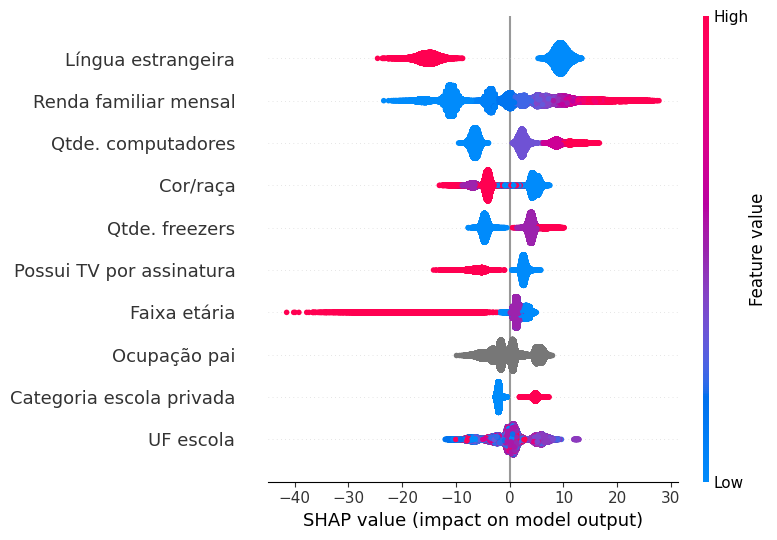

In [15]:
# Plotar os valores SHAP
plot_shap_values(shap_values, X_test.columns, 10)

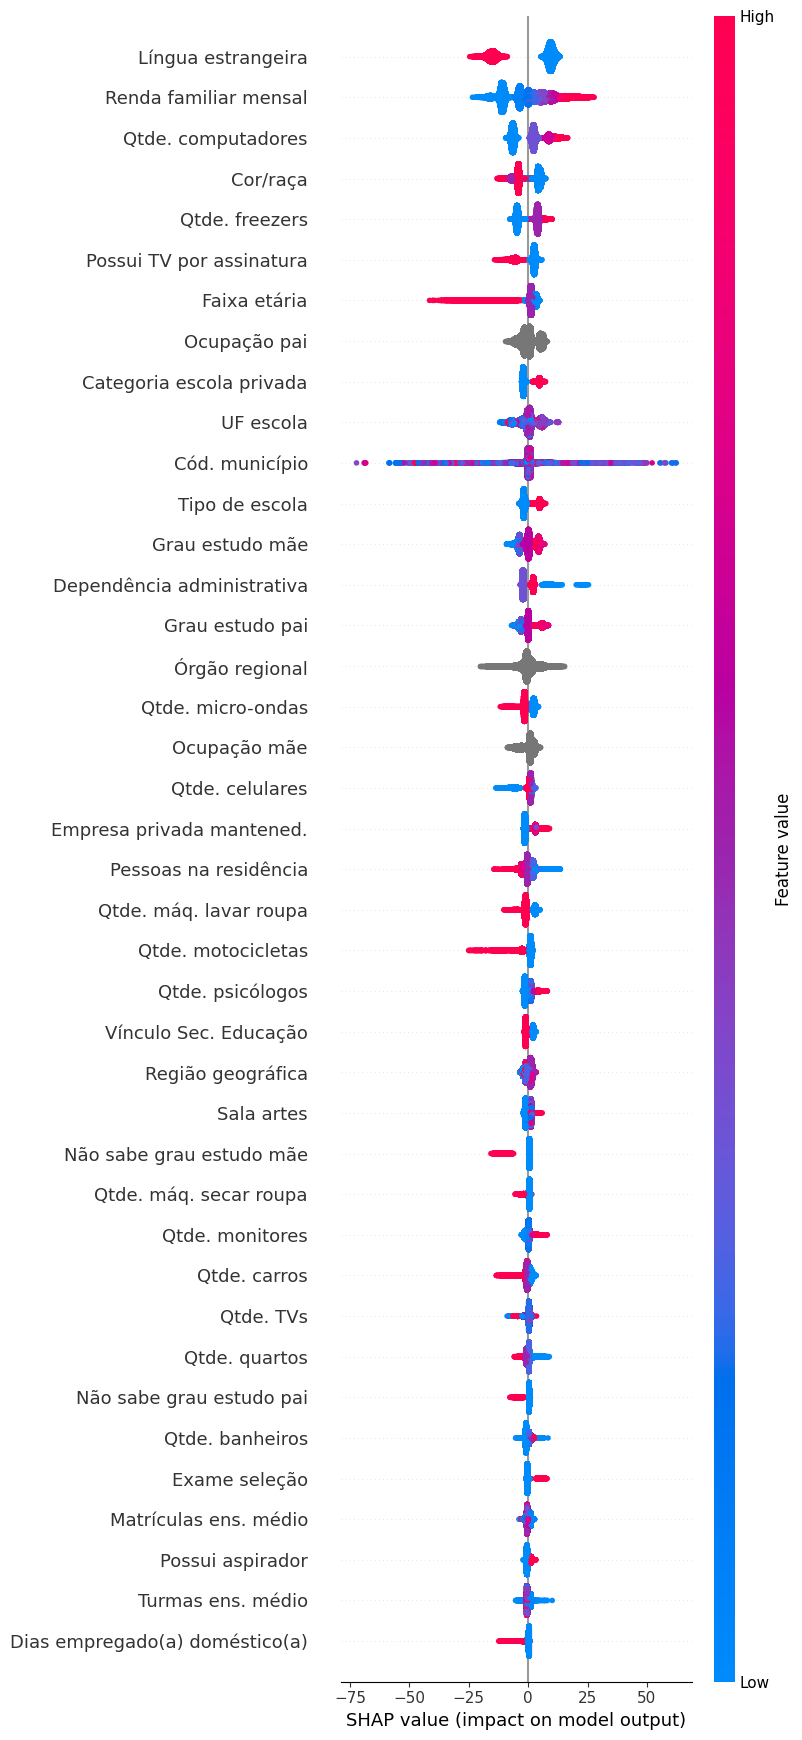

In [16]:
# Plotar os valores SHAP
plot_shap_values(shap_values, X_test.columns, 40)

In [17]:
# 1. Calcule a importância SHAP global (média dos valores absolutos)
if hasattr(shap_values, 'values'):
    # Caso multi-target, escolha o target desejado, ex: shap_values[0]
    shap_array = shap_values.values
    if shap_array.ndim == 3:  # (amostras, targets, features)
        shap_array = shap_array[:, 0, :]  # Exemplo: target 0
else:
    shap_array = shap_values

mean_abs_shap = np.abs(shap_array).mean(axis=0)

# 2. Crie um DataFrame com feature, origem e importância SHAP
df_shap = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': mean_abs_shap
})
df_shap['Origem'] = df_shap['Feature'].map(origens_base)

# 3. Agrupe por origem e some as importâncias
df_shap_grouped = df_shap.groupby('Origem')['SHAP_Importance'].sum().reset_index()

# 4. Calcule a porcentagem
df_shap_grouped['SHAP_Importance (%)'] = 100 * df_shap_grouped['SHAP_Importance'] / df_shap_grouped['SHAP_Importance'].sum()

print(df_shap_grouped.sort_values('SHAP_Importance (%)', ascending=False))

          Origem  SHAP_Importance  SHAP_Importance (%)
2           ENEM        73.284364            68.387631
1  CENSO ESCOLAR        25.830687            24.104726
0          AMBAS         8.045211             7.507644


In [18]:
# 1. Calcule a importância SHAP global (média dos valores absolutos)
if hasattr(shap_values, 'values'):
    shap_array = shap_values.values
    if shap_array.ndim == 3:  # (amostras, targets, features)
        shap_array = shap_array[:, 0, :]  # Exemplo: target 0
else:
    shap_array = shap_values

mean_abs_shap = np.abs(shap_array).mean(axis=0)

# 2. DataFrame com feature, origem (tipo) e importância SHAP
df_shap_tipo = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': mean_abs_shap
})
df_shap_tipo['Origem'] = df_shap_tipo['Feature'].map(origens_tipo)

# 3. Agrupe por origem (tipo) e some as importâncias
df_shap_tipo_grouped = df_shap_tipo.groupby('Origem')['SHAP_Importance'].sum().reset_index()

# 4. Calcule a porcentagem
df_shap_tipo_grouped['SHAP_Importance (%)'] = 100 * df_shap_tipo_grouped['SHAP_Importance'] / df_shap_tipo_grouped['SHAP_Importance'].sum()

print(df_shap_tipo_grouped.sort_values('SHAP_Importance (%)', ascending=False))

           Origem  SHAP_Importance  SHAP_Importance (%)
1  SOCIOECONOMICO        70.225164            65.532841
0       ESCOLARES        36.935097            34.467159


In [19]:
# Cria um dataframe que traga 4 colunas: nome descritivo da variável, posição da variável na importancia SHAP, posição da variável na importancia Gain, posição da variável na importancia Split
df_importancia = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Importance': mean_abs_shap,
    'Gain (%)': df_comparado.set_index('Feature')['Gain (%)'],
    'Split (%)': df_comparado.set_index('Feature')['Split (%)']
})

# Adiciona a coluna de nomes descritivos
df_importancia['Feature_Desc'] = df_importancia['Feature'].map(nomes_descritivos).fillna(df_importancia['Feature'])
# Ordena o dataframe por SHAP_Importance
df_importancia = df_importancia.sort_values(by='SHAP_Importance', ascending=False).reset_index(drop=True)
# Adiciona a posição de cada variável em cada métrica
df_importancia['SHAP_Rank'] = df_importancia['SHAP_Importance'].rank(ascending=False, method='min').astype(int)
df_importancia['Gain_Rank'] = df_importancia['Gain (%)'].rank(ascending=False, method='min').astype(int)
df_importancia['Split_Rank'] = df_importancia['Split (%)'].rank(ascending=False, method='min').astype(int)
# Exibe o dataframe final
display(df_importancia[['Feature_Desc', 'SHAP_Rank', 'Gain_Rank', 'Split_Rank']].sort_values(by='SHAP_Rank'))


,Feature_Desc,SHAP_Rank,Gain_Rank,Split_Rank
0,Língua estrangeira,1,2,60
1,Renda familiar mensal,2,1,6
2,Qtde. computadores,3,4,29
3,Cor/raça,4,11,27
4,Qtde. freezers,5,24,42
...,...,...,...,...
101,Localização diferenciada,102,104,104
102,Sem energia,103,103,97
103,Sem água,104,102,101
104,Vínculo Sec. Saúde,105,105,106


In [20]:
df_importancia.drop(columns=['Feature', 'SHAP_Importance', 'Gain (%)', 'Split (%)'], inplace=True)

df_importancia.rename(columns={
    'Feature_Desc': 'Variáveis',
    'SHAP_Rank': 'Posição SHAP',
    'Gain_Rank': 'Posição Ganho',
    'Split_Rank': 'Posição Split'
}, inplace=True)

# Salvar com xlsx
df_importancia.to_excel('Referencia_Variaveis\Importancia_Variaveis.xlsx', index=False)